<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/LEE/new_start_codeBert_2jin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install datasets

In [38]:
import pandas as pd

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/model train/Last_train2(feature).csv')

In [40]:
df

,CWE ID,code,vul,lang,labels,Unnamed: 0,chmod(),assert(),atoi(),atof(),...,int,short,long,long long,unsigned int,unsigned short,unsigned long,unsigned long long,line_count,function_name
0,CWE-20,unsigned long convert_rip_to_linear(struct tas...,1,c,2,NaN,0,0,0,0,...,0,0,3,0,0,0,3,0,29,NaN
1,CWE-20,static unsigned long convert_eip_to_linear(str...,1,c,2,NaN,0,0,0,0,...,0,0,3,0,0,0,3,0,33,NaN
2,CWE-399,static int pwc_video_close(struct inode *inode...,1,cpp,9,NaN,0,0,0,0,...,2,0,0,0,0,0,0,0,42,pwc_video_close
3,CWE-399,static void usb_pwc_disconnect(struct usb_inte...,1,c,9,NaN,0,0,0,0,...,1,0,0,0,0,0,0,0,48,usb_pwc_disconnect
4,CWE-20,asmlinkage long sys_setrlimit(unsigned int res...,1,cpp,2,NaN,0,0,0,0,...,2,0,4,0,1,0,2,0,63,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18501,CWE-416,void func() {\n\t wchar_t * data; /* Ini...,1,cpp,10,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,7,func
18502,CWE-416,void func() {\n\t wchar_t * data; /* Ini...,1,cpp,10,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,7,func
18503,CWE-121,void func() {\n\t wchar_t * data; other_...,1,c,5,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,7,func
18504,CWE-121,static void func(wchar_t * data) {\n\t {\n...,1,c,5,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,7,func


In [41]:
df = df[['code','vul']]

In [42]:
import pandas as pd
import re
import transformers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from pandas.core.common import random_state
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import logging
import sklearn.metrics as metric
from transformers import DataCollatorWithPadding
import torch,gc
from sklearn.metrics.pairwise import cosine_similarity
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from transformers import RobertaForSequenceClassification, RobertaTokenizer, TrainingArguments, Trainer

In [43]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
batch_size = 16
epoch_num = 1000
MAX_LEN = 512
learning_rate = 2e-5

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
import re

def preprocess(df, file_name):
    # 멀티 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df['code'] = df['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df.to_csv(file_name, index=False)
    return df  # 수정된 데이터프레임 반환

def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [58]:
preprocess(df,"preprocess.csv")
dataset = load_dataset("csv",data_files="preprocess.csv")['train']
encoded_dataset = dataset.map(tokenized,remove_columns=['code'],batched=True)
encoded_dataset=encoded_dataset.rename_column(original_column_name='vul',new_column_name='labels')

<ipython-input-57-5f6a1297a3d9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
<ipython-input-57-5f6a1297a3d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
<ipython-input-57-5f6a1297a3d9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/18506 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [59]:
encoded_dataset = encoded_dataset.train_test_split(0.3,seed=100)

In [60]:
optimizer = torch.optim.AdamW(model.parameters(),
            lr = learning_rate, betas=(0.9,0.99), eps=1e-8,
            weight_decay=0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                        num_warmup_steps=5, num_training_steps=5)
optimizers = optimizer, scheduler

In [61]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 가중 평균, 매크로 평균, 마이크로 평균 F1 스코어 계산
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # 결과를 딕셔너리 형태로 저장
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    return metrics

In [63]:
from transformers import TrainerCallback
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')

        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluation steps. Stopping training early.")
                control.should_training_stop = True

        # Evaluate를 위한 DataLoader 설정 및 평가 로직
        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels

            if incorrect_mask.any():
                incorrect_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                self.incorrect_samples.append(incorrect_samples)

        print("Collected incorrect predictions for further analysis.")

In [64]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1000,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)
callback = CustomTrainerCallback(encoded_dataset['test'], 5)

# 트레이너 초기화 및 사용자 정의 콜백 추가

# 콜백 인스턴스 생성 및 트레이너 초기화

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)
callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)

In [65]:
gc.collect()
torch.cuda.empty_cache()

In [67]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro
500,0.313300,0.157696,0.955692,0.955692,0.954531,0.908462,0.955692
1000,0.165700,0.102778,0.967039,0.967039,0.965834,0.930601,0.967039
1500,0.137100,0.163396,0.963437,0.963437,0.962033,0.922761,0.963437


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro
500,0.313300,0.157696,0.955692,0.955692,0.954531,0.908462,0.955692
1000,0.165700,0.102778,0.967039,0.967039,0.965834,0.930601,0.967039
1500,0.137100,0.163396,0.963437,0.963437,0.962033,0.922761,0.963437
2000,0.121000,0.119230,0.967759,0.967759,0.966717,0.932635,0.967759
2500,0.111700,0.111142,0.971902,0.971902,0.971182,0.942014,0.971902
3000,0.117100,0.142891,0.968660,0.968660,0.968256,0.936864,0.968660
3500,0.115200,0.135206,0.969380,0.969380,0.968177,0.935210,0.969380


Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
Collected incorrect predictions for further analysis.
No improvement in 5 evaluation steps. Stopping training early.
Collected incorrect predictions for further analysis.


TrainOutput(global_step=3500, training_loss=0.15443012019566127, metrics={'train_runtime': 4844.9128, 'train_samples_per_second': 2673.732, 'train_steps_per_second': 133.749, 'total_flos': 1.84098805435392e+16, 'train_loss': 0.15443012019566127, 'epoch': 5.401234567901234})

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


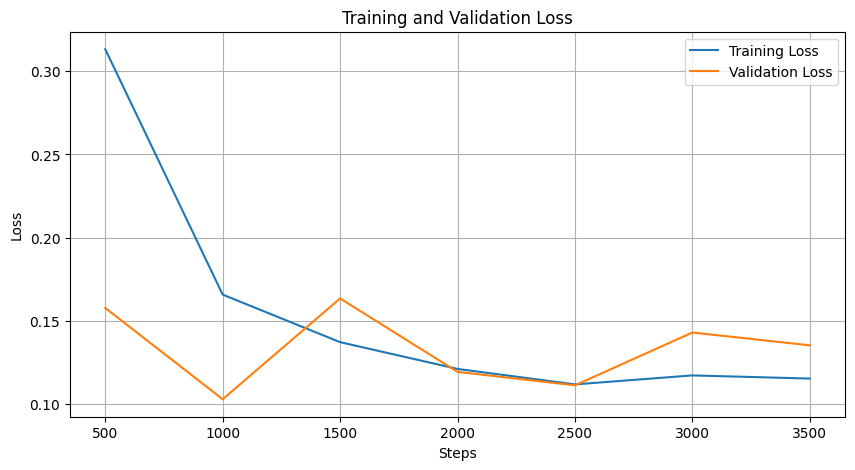

In [68]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

In [70]:
trainer.save_model('/content/drive/MyDrive/models/codebert_1or0')

In [78]:
import pandas as pd

df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/model train/Last_test2(feature).csv")

In [79]:
df2 = df2[['vul', 'code']]

In [80]:
import re

def preprocess2(df2, file_name):
    # 멀티 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df2['code'] = df2['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df2['code'] = df2['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df2['code'] = df2['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df2['code'] = df2['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df2['code'] = df2['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df2['code'] = df2['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df2.to_csv(file_name, index=False)
    return df2  # 수정된 데이터프레임 반환


def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [82]:
preprocess2(df2,"preprocess2.csv")
dataset = load_dataset("csv",data_files="preprocess2.csv")['train']
encoded_dataset2 = dataset.map(tokenized,remove_columns=['code'],batched=True)
encoded_dataset2=encoded_dataset2.rename_column(original_column_name='vul',new_column_name='labels')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [84]:
trainer.predict(encoded_dataset2, metric_key_prefix="eval")

PredictionOutput(predictions=array([[-2.8796616,  2.644861 ],
       [-1.4045453,  1.2921764],
       [-2.328151 ,  2.048652 ],
       [-3.1126466,  3.0389874],
       [-3.0834968,  2.9540389],
       [-2.9676552,  2.7755444],
       [-3.118221 ,  3.0351334],
       [-3.0545268,  2.8963778],
       [-3.1067603,  3.0437381],
       [-3.1198318,  3.0368013],
       [-2.771185 ,  2.525446 ],
       [-2.3620033,  2.001988 ],
       [-2.5048025,  2.2292724],
       [-3.1297715,  3.0294516],
       [-3.1180217,  3.0342631],
       [-3.108827 ,  3.0414681],
       [-2.7128377,  2.4564106],
       [-2.844907 ,  2.618369 ],
       [-1.1880306,  1.0614173],
       [-1.3671408,  1.1376022],
       [-2.810217 ,  2.5788038],
       [-2.6347556,  2.3695683],
       [-2.5708926,  2.2989433],
       [-2.762069 ,  2.5238762],
       [-3.0746145,  2.937478 ],
       [-2.1166852,  1.8116872],
       [-3.1148021,  3.0388703],
       [-2.591726 ,  2.3247433],
       [-3.0896099,  2.9550085],
       [-1.786